## Initialize: import necessary dependencies 

In [5]:
import os
import shutil
import cv2
import pandas as pd

# Overview

## Upload and organize folders with multi-trial recordings from UCLA Miniscope software into output folders to streamline downstream behavior and calcium extraction analyses.

**Consolidate**
* Organize imaging/behavior videos recorded in a single day for one animal into a single folder. The imaging field of view must be consistent for all data folders being processed (ie miniscope was not removed from the animal between recording sessions).
>**Why consolidate behavior and imaging videos?** Performing calcium extraction analysis (ie MiniAn, CNMF-E) on independent trials requires additional analysis to match cells between trials. This is an unnecessary time consuming and often tricky step if the trials were recorded in the same day without removing the miniscope from the animal.

**Concatenate**
* Concatenate (ie merge together) all behavior videos and corresponding timestamp files. Many post-processing position analysis pipelines, like DeepLabCut, do not have a function that does this. 
* Imaging videos will *not* be be concatenated because many calcium extraction pipelines include this step (ie MiniAn). However, corresponding imaging timestamp and head orientaion files will be concatenated. 

**Downsample (abbreviated: ds)**
* Downsample the merged *behavior* video and its corresponding timestamp file by a user-defined `downsample_factor`. Both the original and downsampled files will be saved. (**downsample is abbreviated "ds" in filenames**) 
>**Why downsample behavior video?** In later steps not included in this notebook, the user may decide to downsample the *imaging* videos to make downstream calcium extraction more efficient. Before moving forward with position analysis of behavior videos, the user should decide whether to use the original or downsampled videos. This will all depend on how calcium signals are extracted. Aligning behavior-imaging data will be significantly simpler if both imaging AND behavior videos are post-processed using the same sampling rate. 

<div class="alert alert-info">
<strong>Input folder structure</strong>

**EXAMPLE:** For a given `projectID`, behavior and calcium imaging data is recorded for `animalID` over several trials in `experimentID`. Between trials, the recording software is stopped and the miniscope LED is turned off, but not removed from the animal. The trials will be saved into separate `recording_folders` using the default folder structure set by the UCLA Miniscope software. This notebook will re-organize and concatenate the trials into `output_folders` so they can be more easily analyzed as a single session: 
    
This notebook assumes that the data in `recording_folders` are stored in hierarchically arranged folders created from UCLA Miniscope software, as shown below:

</div>

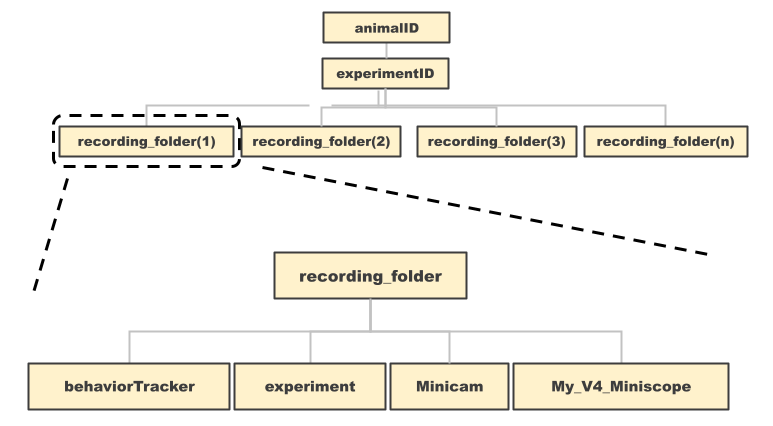

<div class="alert alert-info">
<strong>Output folder structure</strong>

</div>

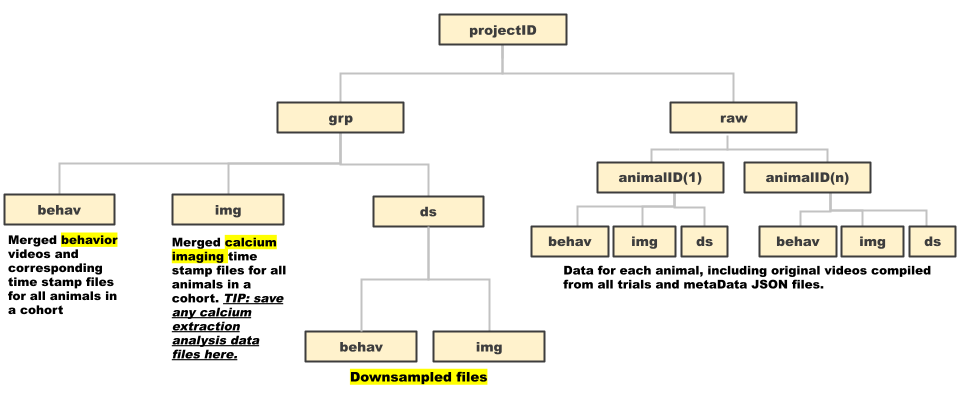

## Filename structure

<div class="alert alert-info">
<strong>Provide animal and experiment info to create unique filenames:</strong>

`animalID` and `experimentID` will be used to create a `fileID` to rename and save files in `output_folder`. This is an opportunity to ensure filenames are both specific enough to distinguish animals in a cohort, but general enough to easily group experiments or conditions. *Try to consider downstream analyses and how animals and/or experiments will be grouped when developing naming conventions.*

* `animalID:` Include 'M' (male) or 'F'(female) along with number of animal.
* `experimentID:` Be concise and consistent with experiment descriptions. Try not to use spaces or special characters. Dates are not recommended.

**Good examples**
* `animalID = M1`,`animalID = M1`, `animalID = M1`
* `experimentID = baseline`, `experimentID = 5sdelay`, `experimentID = 5sec`

**Not as good examples**
* `animalID = 1`, `animalID = M1_ctrl`, `animalID = M1_stress`
* `experimentID = 100323_baseline`, `experimentID = 5_s_delay`, `experimentID = delay_5s`
    
</div>

<div class="alert alert-info">
<strong>Specify directories to pull and put data:</strong>

* `recording_folders:` Folder for each recording session containing "Minicam" & "My_V4_Miniscope" subfolders
* `output_folder:` directory where data will be saved using `fileID` to create unique filenames and subfolders

</div>

## Set path

In [12]:
# Animal and experiment information
animalID='M9014'
experimentID='TEST'

#List of parent folder directories (in the order you want)
parent_folders = [
    "H:/COHORT4/F5937/ss2_062422_1",
    "H:/COHORT4/F5937/ss2_062422_2",
    # Add more folders as needed
]

#Directory where compiled behavior and imaging files will be saved
output_folder = "H:/COHORT4/Pilot" 

#Downsampling factor
downsample_factor = 2

# Behavior video processing

In [3]:
#Prefix for "_mergedVideo.avi" file
fileID= animalID + '_' + experimentID

#Directory with copy of all merged behavior videos and timestamp files
behavior_video_folder = output_folder + '/Behavior_positionAnalysis'
#Directory with copy of all imaging timestamp files videos
imaging_video_folder = output_folder + '/Imaging_calciumAnalysis'

output_folder = output_folder + '/' + fileID

# Function to get a list of all CSV files containing "_timeStamps.csv"
def get_timestamp_csv_files(folder):
    timestamp_csv_files = [f for f in os.listdir(folder) if f.endswith('.csv') and "_timeStamps.csv" in f]
    return timestamp_csv_files

# Function to get a list of all AVI files and sort them by name
def get_sorted_avi_files(folder):
    avi_files = [f for f in os.listdir(folder) if f.endswith('.avi')]
    avi_files.sort()
    return avi_files

def update_concatenated_timeStamps(compiled_folder, csv_file, fileID):
    file_path = os.path.join(compiled_folder, csv_file)

    # Initialize an empty DataFrame to store the concatenated data
    concatenated_data = pd.DataFrame()

    # Initialize a variable to keep track of the total frame count
    total_frames = 0

    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Rename "Frame" to "Frame Rate" and "Time" to "Time Stamp (ms)"
        df = df.rename(columns={'Frame Number': 'Frame', 'Time Stamp (ms)': 'Time'})
        
         # Remove the 3rd column
        df = df.drop(columns=['Buffer Index'])
        
        # Add a 'Frame' column that counts from 1 to the end of the column
        df['Frame Number'] = range(1, len(df) + 1)

        # Calculate the sampling frequency from the 'Time Stamp (ms)' column
        sampling_frequency = 1000 / (df['Time'].iloc[1] - df['Time'].iloc[0])

        # Add a 'Time (ms)' column that counts up from 0 using the sampling frequency interval
        df['Time Stamp(ms)'] = [i / sampling_frequency for i in range(len(df))]
        
         # Remove the 1st column
        df = df.drop(columns=['Frame'])
        
        # Remove the 2nd column
        df = df.drop(columns=['Time'])

        # Append the data to the concatenated_data DataFrame
        concatenated_data = concatenated_data.append(df, ignore_index=True)

        # Update the total frame count
        total_frames += len(df)
        
       
    else:
        print(f"File '{csv_file}' not found in folder '{compiled_folder}'")

    # Extract the base name (without extension)
    base_name = os.path.splitext(csv_file)[0]

    # Get the last part of the base name
    last_part = base_name.split("_")[-1]

    # Save the concatenated data to a new CSV file
    name = fileID + '_' + last_part + '.csv'
    concatenated_data.to_csv(os.path.join(compiled_folder, name), index=False)

# Function to process Minicam folders
def process_minicam_folders(parent_folders, output_folder):
    compiled_folder = os.path.join(output_folder, "Behavior")
    os.makedirs(compiled_folder, exist_ok=True)
    
    concatenated_timestamps = pd.DataFrame()  # Initialize an empty DataFrame to store concatenated timestamps
    
    for index, parent_folder in enumerate(parent_folders):
        avi_files = get_sorted_avi_files(os.path.join(parent_folder, "Minicam"))
        #timestamps_file = os.path.join(parent_folder, "Minicam", "timeStamps.csv")
        timestamp_csv_files = get_timestamp_csv_files(os.path.join(parent_folder, "Minicam"))


        # Copy AVI files to Behavior compiled folder and rename
        for i, avi_file in enumerate(avi_files):
            new_name = f"{index * len(avi_files) + i}.avi"  # Corrected naming here
            shutil.copy(os.path.join(parent_folder, "Minicam", avi_file), os.path.join(compiled_folder, new_name))
            
        # Copy timestamps file and rename
        for timestamp_file in timestamp_csv_files:
            new_timestamps_name = f"{index}_{timestamp_file}"
            shutil.copy(os.path.join(parent_folder, "Minicam", timestamp_file), os.path.join(compiled_folder, new_timestamps_name))
            timestamps_data = pd.read_csv(os.path.join(compiled_folder, new_timestamps_name))
            # Concatenate to the main DataFrame
            concatenated_timestamps = pd.concat([concatenated_timestamps, timestamps_data])
            os.remove(os.path.join(compiled_folder, new_timestamps_name))
            
    # Save the concatenated timestamps to a new file
    nameA = "timeStamps.csv"
    concatenated_timestamps.to_csv(os.path.join(compiled_folder, nameA), index=False)

    # Create a downsampled version of the timestamps DataFrame (downsampled by 2)
    downsampled_timestamps = concatenated_timestamps.iloc[::2].reset_index(drop=True)
    nameB = "timeStampsDownsampled.csv"
    downsampled_timestamps.to_csv(os.path.join(compiled_folder, nameB), index=False)

    update_concatenated_timeStamps(compiled_folder, nameA, fileID)
    update_concatenated_timeStamps(compiled_folder, nameB, fileID)

    os.remove(os.path.join(compiled_folder, nameA))
    os.remove(os.path.join(compiled_folder, nameB))
    
            
    # Check and adjust frame rate to 30 FPS (assuming all AVIs have the same frame rate)
    for avi_file in avi_files:
        video_path = os.path.join(compiled_folder, f"{index * len(avi_files) + i}.avi")  # Corrected naming here
        cap = cv2.VideoCapture(video_path)
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if frame_rate != 30:
            print(f"Changing frame rate for {video_path} to 30 FPS")
            out = cv2.VideoWriter(
                video_path.replace(".avi", "_30fps.avi"),
                cv2.VideoWriter_fourcc(*'XVID'),
                30,
                (int(cap.get(3)), int(cap.get(4)))
            )
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                out.write(frame)
            cap.release()
            out.release()
            os.remove(video_path)
            os.rename(video_path.replace(".avi", "_30fps.avi"), video_path)


# Function to concatenate AVI videos
def concatenate_avi_videos(input_folder, output_file):
    video_files = [f for f in os.listdir(input_folder) if f.endswith('.avi')]
    video_files.sort()

    frames = []
    
    for file in video_files:
        video = cv2.VideoCapture(os.path.join(input_folder, file))

        while True:
            ret, frame = video.read()
            if not ret:
                break
            frames.append(frame)

        video.release()

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    output = cv2.VideoWriter(output_file, fourcc, 30, (frames[0].shape[1], frames[0].shape[0]))

    for frame in frames:
        output.write(frame)

    output.release()
    
# Function to downsample an AVI video by 2 and reduce the video length
def downsample_avi_video(input_file, output_file, downsample_factor):
    cap = cv2.VideoCapture(input_file)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    frame_rate = int(cap.get(5))
    
    new_frame_width = frame_width 
    new_frame_height = frame_height
    new_frame_rate = frame_rate# * downsample_factor
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_file, fourcc, new_frame_rate, (new_frame_width, new_frame_height))
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Downsample the frame by 2
        if frame_count % downsample_factor == 0:
            frame = cv2.resize(frame, (new_frame_width, new_frame_height))
            out.write(frame)
        
        frame_count += 1
    
    cap.release()
    out.release()

# Ensure the output_folder exists, or create it if it doesn't
os.makedirs(output_folder, exist_ok=True)

# Process Minicam folders
process_minicam_folders(parent_folders, output_folder)

# Concatenate AVI videos from the Imaging compiled folder
name=fileID + '_mergedVideo.avi'
concatenated_video_output = os.path.join(output_folder,"Behavior", name)
concatenate_avi_videos(os.path.join(output_folder, "Behavior"), concatenated_video_output)

nameDownsampled=fileID + '_mergedVideoDownsampled.avi'
output_video_path = os.path.join(output_folder, "Behavior", nameDownsampled)
downsample_avi_video(concatenated_video_output, output_video_path, downsample_factor)

# Move merged videos to shared folder for postion analysis (ie DeepLabCut)

# Use the user-defined folder to create a downsampled folder
downsampled_behavior_video_folder = behavior_video_folder + '_Downsampled'

# Ensure the behavior_video_folder exists, or create it if it doesn't
os.makedirs(behavior_video_folder, exist_ok=True)

# Ensure the downsampled_behavior_video_folder exists, or create it if it doesn't
os.makedirs(downsampled_behavior_video_folder, exist_ok=True)

# Copy the concatenated video to the behavior_video_folder
shutil.copy(concatenated_video_output, behavior_video_folder)

# Copy the concatenated video to the behavior_video_folder
shutil.copy(concatenated_video_output, downsampled_behavior_video_folder)


print("Video concatenation complete. The concatenated video is saved as 'mergedVideo.avi'.")
print("Video downsampling complete. The downsampled video is saved as '_mergedVideoDownsampled.avi'.")


Video concatenation complete. The concatenated video is saved as 'mergedVideo.avi'.
Video downsampling complete. The downsampled video is saved as '_mergedVideoDownsampled.avi'.


# Imaging video processing

In [13]:
#Combine videos from trials in a single day's session, including time stamp files

# Put My_V4_Miniscope videos into Imaging compiled folder

# Function to get a list of all CSV files containing "_timeStamps.csv"
def get_timestamp_csv_files(folder):
    timestamp_csv_files = [f for f in os.listdir(folder) if f.endswith('.csv') and "_timeStamps.csv" in f]
    return timestamp_csv_files

def get_head_orientation_csv_files(folder):
    head_orientation_csv_files = [f for f in os.listdir(folder) if f.endswith('.csv') and "_headOrientation.csv" in f]
    return head_orientation_csv_files

# Function to get a list of all AVI files and sort them by name
def get_sorted_avi_files(folder):
    avi_files = [f for f in os.listdir(folder) if f.endswith('.avi')]
    avi_files.sort()
    return avi_files

def update_concatenated_timeStamps(compiled_folder, csv_file, fileID):
    file_path = os.path.join(compiled_folder, csv_file)

    # Initialize an empty DataFrame to store the concatenated data
    concatenated_data = pd.DataFrame()

    # Initialize a variable to keep track of the total frame count
    total_frames = 0

    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Rename "Frame Rate" to "Frame"; and "Time Stamp (ms)" to "Time"
        df = df.rename(columns={'Frame Number': 'Frame', 'Time Stamp (ms)': 'Time'})
        
         # Remove the 3rd column
        df = df.drop(columns=['Buffer Index'])
        
        # Add a 'Frame' column that counts from 1 to the end of the column
        df['Frame Number'] = range(1, len(df) + 1)

        # Calculate the sampling frequency from the 'Time Stamp (ms)' column
        sampling_frequency = 1000 / (df['Time'].iloc[1] - df['Time'].iloc[0])

        # Add a 'Time (ms)' column that counts up from 0 using the sampling frequency interval
        df['Time Stamp(ms)'] = [i / sampling_frequency for i in range(len(df))]
        
         # Remove the 1st column
        df = df.drop(columns=['Frame'])
        
        # Remove the 2nd column
        df = df.drop(columns=['Time'])

        # Append the data to the concatenated_data DataFrame
        concatenated_data = concatenated_data.append(df, ignore_index=True)

        # Update the total frame count
        total_frames += len(df)
        
    else:
        print(f"File '{csv_file}' not found in folder '{compiled_folder}'")

    # Extract the base name (without extension)
    base_name = os.path.splitext(csv_file)[0]

    # Get the last part of the base name
    last_part = base_name.split("_")[-1]

    # Save the concatenated data to a new CSV file
    name = fileID + '_' + last_part + '.csv'
    concatenated_data.to_csv(os.path.join(compiled_folder, name), index=False)


    # Print the total frame count
    print(f"Total frames timestamp file: {total_frames}")

def update_concatenated_headorientation(compiled_folder, csv_file, fileID):
    file_path = os.path.join(compiled_folder, csv_file)

    # Initialize an empty DataFrame to store the concatenated data
    concatenated_data = pd.DataFrame()

    # Initialize a variable to keep track of the total frame count
    total_frames = 0

    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Rename "Time Stamp (ms)" to "Time"
        df = df.rename(columns={'Time Stamp (ms)': 'Time'})
        
        # Add a 'Frame' column that counts from 1 to the end of the column
        df['Frame Number'] = range(1, len(df) + 1)

        # Calculate the sampling frequency from the 'Time Stamp (ms)' column
        sampling_frequency = 1000 / (df['Time'].iloc[1] - df['Time'].iloc[0])

        # Add a 'Time (ms)' column that counts up from 0 using the sampling frequency interval
        df['Time Stamp(ms)'] = [i / sampling_frequency for i in range(len(df))]
        
        # Remove the 2nd column
        df = df.drop(columns=['Time'])

        # Append the data to the concatenated_data DataFrame
        concatenated_data = concatenated_data.append(df, ignore_index=True)

        # Update the total frame count
        total_frames += len(df)
        
    else:
        print(f"File '{csv_file}' not found in folder '{compiled_folder}'")

    # Extract the base name (without extension)
    base_name = os.path.splitext(csv_file)[0]

    # Get the last part of the base name
    last_part = base_name.split("_")[-1]

    # Save the concatenated data to a new CSV file
    name = fileID + '_' + last_part + '.csv'
    concatenated_data.to_csv(os.path.join(compiled_folder, name), index=False)


    # Print the total frame count
    print(f"Total frames head orientation file: {total_frames}")

def process_imaging_folders(parent_folders, output_folder):
    compiled_folder = os.path.join(output_folder, "Imaging")
    os.makedirs(compiled_folder, exist_ok=True)

    concatenated_timestamps = pd.DataFrame()  # Initialize an empty DataFrame to store concatenated timestamps
    concatenated_headorientation = pd.DataFrame()  # Initialize an empty DataFrame to store concatenated timestamps

    for index, parent_folder in enumerate(parent_folders):
        avi_files = get_sorted_avi_files(os.path.join(parent_folder, "My_V4_Miniscope"))
        timestamp_csv_files = get_timestamp_csv_files(os.path.join(parent_folder, "My_V4_Miniscope"))

        #head_orientation_file = os.path.join(parent_folder, "My_V4_Miniscope", "headOrientation.csv")
        head_orientation_csv_files = get_head_orientation_csv_files(os.path.join(parent_folder, "My_V4_Miniscope"))


        # Copy AVI files to Imaging compiled folder and rename
        for i, avi_file in enumerate(avi_files):
            new_name = f"{index * len(avi_files) + i}.avi"  # Corrected naming here
            shutil.copy(os.path.join(parent_folder, "My_V4_Miniscope", avi_file), os.path.join(compiled_folder, new_name))
            print(f"Processing file {i + 1}/{len(avi_files)} in folder {parent_folder}")
            
        # Copy timestamps file and rename
        for timestamps_file in timestamp_csv_files:
            new_timestamps_name = f"{index}_{timestamps_file}"
            shutil.copy(os.path.join(parent_folder, "My_V4_Miniscope", timestamps_file), os.path.join(compiled_folder, new_timestamps_name))   
            timestamps_data = pd.read_csv(os.path.join(compiled_folder, new_timestamps_name))
            # Concatenate to the main DataFrame
            concatenated_timestamps = pd.concat([concatenated_timestamps, timestamps_data])
            os.remove(os.path.join(compiled_folder, new_timestamps_name))
            
    
        # Copy head orientation file and rename
        for head_orientation_file in head_orientation_csv_files:
            new_head_orientation_name = f"{index}_headOrientation.csv"
            shutil.copy(os.path.join(parent_folder, "My_V4_Miniscope", head_orientation_file), os.path.join(compiled_folder, new_head_orientation_name))
            headorientation_data = pd.read_csv(os.path.join(compiled_folder, new_head_orientation_name))
            # Concatenate to the main DataFrame
            concatenated_headorientation = pd.concat([concatenated_headorientation, headorientation_data])
            os.remove(os.path.join(compiled_folder, new_head_orientation_name))

    # Save the concatenated timestamps to a new file
    nameA = fileID + "_timeStamps.csv"
    concatenated_timestamps.to_csv(os.path.join(compiled_folder, nameA), index=False)

    # Create a downsampled version of the timestamps DataFrame (downsampled by 2)
    downsampled_timestamps = concatenated_timestamps.iloc[::2].reset_index(drop=True)
    nameB = fileID + "_timeStampsDownsampled.csv"
    downsampled_timestamps.to_csv(os.path.join(compiled_folder, nameB), index=False)
    
    # Create new headOrientation file
    nameC = fileID + "_headOrientation.csv"
    concatenated_headorientation.to_csv(os.path.join(compiled_folder, nameC), index=False)
    
    # Create a downsampled version of the headOrientation DataFrame (downsampled by 2)
    downsampled_headorientation = concatenated_headorientation.iloc[::2].reset_index(drop=True)
    nameD = fileID + "_headOrientationDownsampled.csv"
    downsampled_headorientation.to_csv(os.path.join(compiled_folder, nameD), index=False)

    update_concatenated_timeStamps(compiled_folder, nameA, fileID)
    update_concatenated_timeStamps(compiled_folder, nameB, fileID)
    update_concatenated_headorientation(compiled_folder, nameC, fileID)
    update_concatenated_headorientation(compiled_folder, nameD, fileID)
    

# Process Imaging folders
process_imaging_folders(parent_folders, output_folder)

compiled_folder = os.path.join(output_folder, "Imaging")
nameA = os.path.join(compiled_folder, fileID + "_timeStamps.csv")
nameB = os.path.join(compiled_folder, fileID + "_timeStampsDownsampled.csv")
# Move merged videos to shared folder for postion analysis (ie DeepLabCut)

# Use the user-defined folder to create a downsampled folder
downsampled_imaging_video_folder = imaging_video_folder + '_Downsampled'

# Ensure the behavior_video_folder exists, or create it if it doesn't
os.makedirs(imaging_video_folder, exist_ok=True)

# Ensure the downsampled_behavior_video_folder exists, or create it if it doesn't
os.makedirs(downsampled_imaging_video_folder, exist_ok=True)

# Copy the concatenated video to the behavior_video_folder
shutil.copy(nameA, imaging_video_folder)

# Copy the concatenated video to the behavior_video_folder
shutil.copy(nameB, downsampled_imaging_video_folder)

Processing file 1/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 2/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 3/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 4/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 5/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 6/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 7/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 8/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 9/9 in folder H:/COHORT4/F5937/ss2_062422_1
Processing file 1/27 in folder H:/COHORT4/F5937/ss2_062422_2
Processing file 2/27 in folder H:/COHORT4/F5937/ss2_062422_2
Processing file 3/27 in folder H:/COHORT4/F5937/ss2_062422_2
Processing file 4/27 in folder H:/COHORT4/F5937/ss2_062422_2
Processing file 5/27 in folder H:/COHORT4/F5937/ss2_062422_2
Processing file 6/27 in folder H:/COHORT4/F5937/ss2_062422_2
Processing file 7/27 in folder H:/COHORT4/F5937/ss2_062422_2
Processing file 8/27 in folder H:

'H:/COHORT4/Processed/Imaging_calciumAnalysis_Downsampled\\F5937_ss2_timeStampsDownsampled.csv'

# What next? 

1. Behavior --> position analysis (ie DeepLabCut) and pose annotation (manual or automated)
2. Imaging --> calcium extraction (ie MinAn, CNMF-E etc)